### Tải các thư viện cần thiết

In [ ]:
!pip install statsmodels

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.7 MB/s eta 0:00:00


### Import các thư viện cần thiết

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from datetime import timedelta

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Đánh giá mô hình
def calculate_rmse(actual, forecast):
    return np.sqrt(np.mean((np.array(actual) - np.array(forecast)) ** 2))

def calculate_mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def calculate_mae(actual, forecast):
    return np.mean(np.abs(np.array(actual) - np.array(forecast)))


### 1.Áp dụng mô hình để dự đoán cho dữ liệu về giá vàng

#### Kiểm tra tính mùa vụ của toàn bộ dữ liệu

In [ ]:
# Tải dữ liệu từ dataset
df_gold = pd.read_csv('/content/drive/MyDrive/PTDLKD/Dataset/gold_price_2018_2024.csv')


In [ ]:
df_gold.describe()

,Value (USD per troy ounce)
count,2344.000000
mean,1697.579577
std,283.866097
min,1178.569809
25%,1458.163024
50%,1776.887649
75%,1904.391440
max,2434.014476


In [ ]:
# Chuyển đổi kiểu dữ liệu
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
df_gold['Day Number'] = df_gold['Date'].rank(method='dense').astype(int)
df_gold.columns = ['Date', 'Price', 'Day Number']

# Xoá dữ liệu bị null
df_gold = df_gold.dropna()

df_gold

,Date,Price,Day Number
0,2018-01-01,1307.018690,1
1,2018-01-02,1319.827953,2
2,2018-01-03,1311.501862,3
3,2018-01-04,1321.635371,4
4,2018-01-05,1319.589185,5
...,...,...,...
2339,2024-05-28,2353.805161,2340
2340,2024-05-29,2357.459733,2341
2341,2024-05-30,2335.806797,2342
2342,2024-05-31,2346.815711,2343


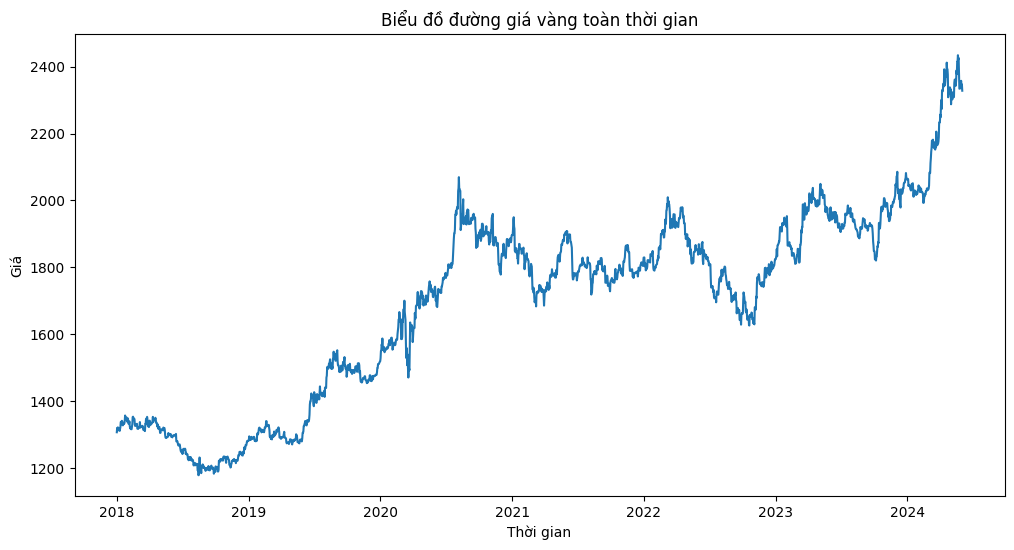

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_gold['Date'],df_gold['Price'])
plt.title('Biểu đồ đường giá vàng toàn thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.show()

- Ở biểu đồ ACF ta nhận thấy độ tương quan các độ trễ (lags) hầu như đều là 1, là rất cao, tương quan mạnh ở mọi độ trễ. Như vậy khả năng có tính mùa vụ là không vì tương quan mạnh ở mọi độ trễ.

- Ở biểu đồ PACF thì AR = 1 (tự hồi quy bậc nhất) là có tương quan mạnh, sau đó thì độ tương quan giảm với các bậc cao hơn. Cùng với dựa biểu đồ thể hiện xu hướng của dữ liệu thì ta thấy dữ liệu giá vàng vẫn có xu hướng tại một số khoảng thời gian xác định vì vậy ta chọn trend = 't' và with_intercept = True.
  + trend = 't': Cho rằng dữ liệu cho xu hướng thay đổi tuyến tính.
  + with_intercept: Khi giá trị này True thì thuộc tính trend mới có tác dụng

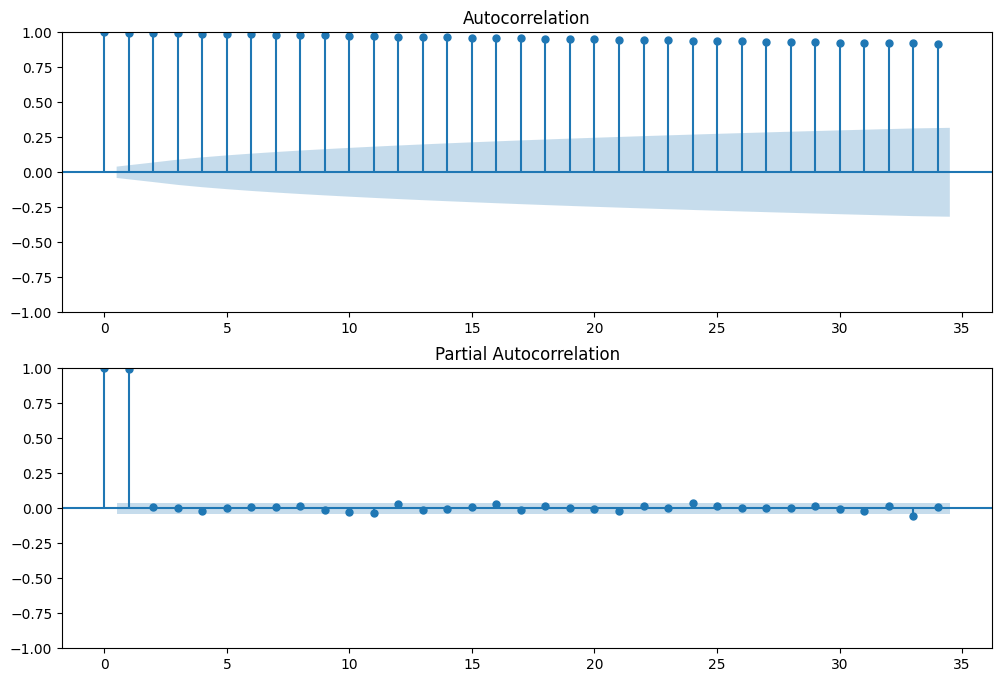

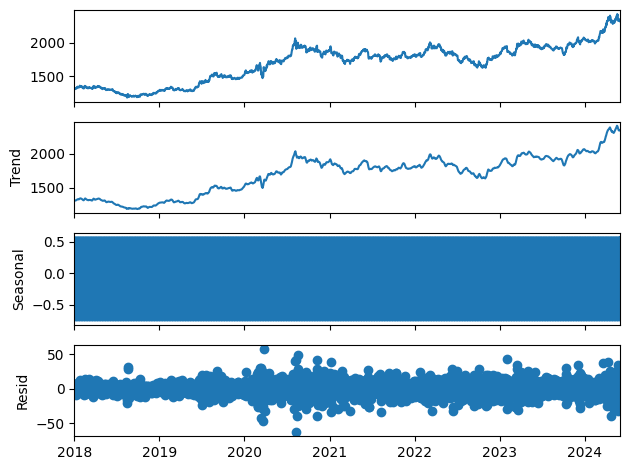

In [ ]:
# ACF và PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_gold['Price'], ax=ax[0])
plot_pacf(df_gold['Price'], ax=ax[1])
plt.show()

# Seasonal decomposition
df_temp = pd.DataFrame({'Price': df_gold['Price'].values}, index=df_gold['Date'])
result = seasonal_decompose(df_temp, model='additive')
result.plot()
plt.show()

#### Chia tập huấn luyện, tập kiểm tra

In [ ]:
# Kích thước tập train, test đối với từng tỉ lệ
train_size_9 = int(0.9 * len(df_gold))
test_size_1 = len(df_gold) - train_size_9
train_size_8 = int(0.8 * len(df_gold))
test_size_2 = len(df_gold) - train_size_8
train_size_7 = int(0.7 * len(df_gold))
test_size_3 = len(df_gold) - train_size_7

print(f'Tỉ lệ 9:1, train: {train_size_9}, test: {test_size_1}')
print(f'Tỉ lệ 8:2, train: {train_size_8}, test: {test_size_2}')
print(f'Tỉ lệ 7:3, train: {train_size_7}, test: {test_size_3}')

Tỉ lệ 9:1, train: 2109, test: 235
Tỉ lệ 8:2, train: 1875, test: 469
Tỉ lệ 7:3, train: 1640, test: 704


In [ ]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
# Dữ liệu huấn luyện được chia thành các phần 9, 8, 7 ứng với các tỉ lệ test/train là 9:1, 8:2, 7:3
g_train_data_9 = df_gold.iloc[:train_size_9]
g_train_data_8 = df_gold.iloc[:train_size_8]
g_train_data_7 = df_gold.iloc[:train_size_7]
g_train_data_9.columns = ['Date','Train Price','Day Number']
g_train_data_8.columns = ['Date','Train Price','Day Number']
g_train_data_7.columns = ['Date','Train Price','Day Number']

# Dữ liệu  được chia thành các phần 1, 2, 3 ứng với các tỉ lệ test/train là 9:1, 8:2, 7:3
g_test_data_1 = df_gold.iloc[train_size_9:]
g_test_data_2 = df_gold.iloc[train_size_8:]
g_test_data_3 = df_gold.iloc[train_size_7:]

g_test_data_1.columns = ['Date', 'Actual Price', 'Day Number']
g_test_data_2.columns = ['Date', 'Actual Price', 'Day Number']
g_test_data_3.columns = ['Date', 'Actual Price', 'Day Number']

#### 1.1 Tỉ lệ train 9:1

##### Tạo, huấn luyện mô hình và dự đoán

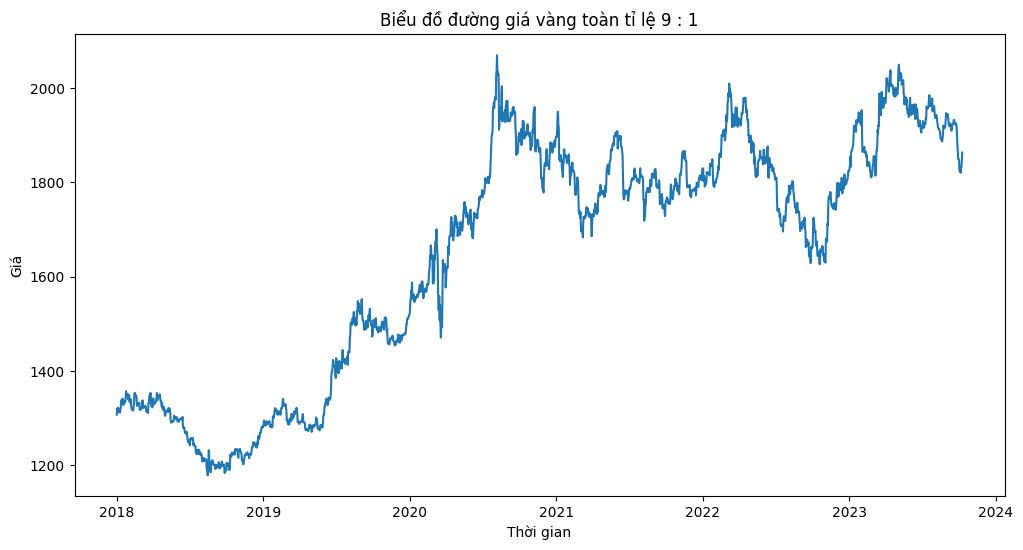

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(g_train_data_9['Date'],g_train_data_9['Price'])
plt.title('Biểu đồ đường giá vàng toàn tỉ lệ 9 : 1')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.show()

In [ ]:
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(g_train_data_9['Train Price'], seasonal=False, with_intercept = True, trend='t', trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16771.592, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16765.510, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16766.557, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16766.539, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16765.510, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16768.503, Time=1.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.945 seconds


In [ ]:
# Fit mô hình với các tham số tốt nhất được tìm kiếm(0, 1, 0)
model = ARIMA(g_train_data_9['Train Price'], order=(0, 1, 0))
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
g_predictions_1 = model_fit.forecast(steps=len(g_test_data_1))

g_test_data_1.insert(1, 'Price Predict', g_predictions_1)

In [ ]:
last_day_number =  (df_gold['Day Number'].max())
last_date = (df_gold['Date'].iloc[-1])

# Dự đoán 90 ngày tiếp theo
n_forecasts = 90
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecasts)
future_day_numbers = range(last_day_number + 1, last_day_number + 1 + n_forecasts)

future_data = pd.DataFrame({'Date': future_dates, 'Day Number': future_day_numbers})
predict_results = model_fit.forecast(steps=(len(g_test_data_1) + len(future_dates)))[-n_forecasts:]
predict_results = np.array(predict_results, dtype=float)
future_data['Price Predict'] = predict_results

future_data

,Date,Day Number,Price Predict
0,2024-06-02,2345,1863.109866
1,2024-06-03,2346,1863.109866
2,2024-06-04,2347,1863.109866
3,2024-06-05,2348,1863.109866
4,2024-06-06,2349,1863.109866
...,...,...,...
85,2024-08-26,2430,1863.109866
86,2024-08-27,2431,1863.109866
87,2024-08-28,2432,1863.109866
88,2024-08-29,2433,1863.109866


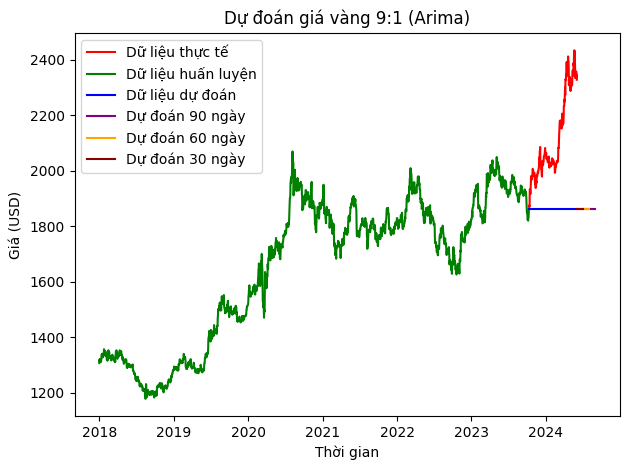

In [ ]:
# Trực quan hóa kết quả
plt.plot(g_test_data_1['Date'], g_test_data_1['Actual Price'], label='Dữ liệu thực tế', color='red')
plt.plot(g_train_data_9['Date'], g_train_data_9['Train Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(g_test_data_1['Date'], g_test_data_1['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data['Date'], future_data['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data['Date'].iloc[31:60], future_data['Price Predict'].iloc[31:60], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data['Date'].iloc[0:30], future_data['Price Predict'].iloc[0:30], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá vàng 9:1 (ARIMA)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

##### Đánh giá mô hình

In [ ]:
rmse = calculate_rmse(g_test_data_1['Actual Price'].values, g_predictions_1.values)
mape = calculate_mape(g_test_data_1['Actual Price'].values, g_predictions_1.values)
mae = calculate_mae(g_test_data_1['Actual Price'].values, g_predictions_1.values)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 295.95911241314275
MAPE: 11.64068735734547%
MAE: 255.52897455572804


#### 1.2 Tỉ lệ train, 8:2

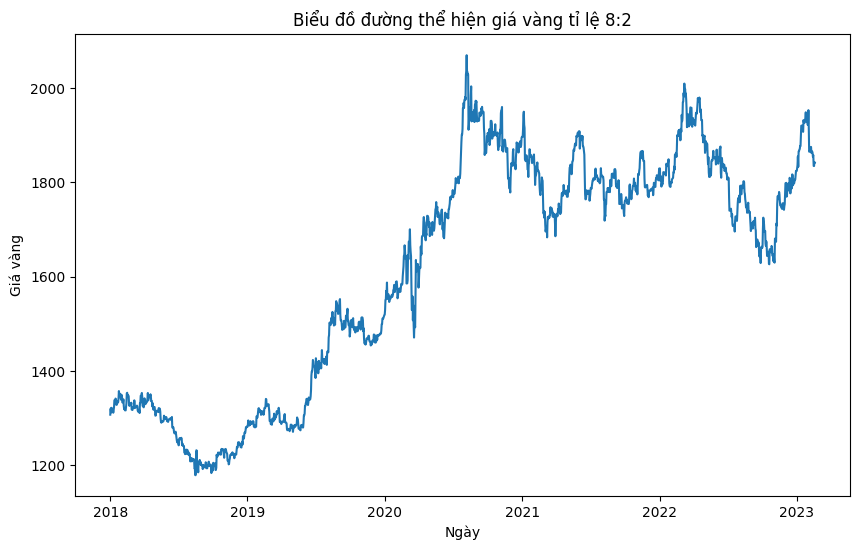

In [ ]:
# Biểu đồ dữ liệu giá vàng ban đầu
plt.figure(figsize=(10, 6))
plt.plot(g_train_data_8['Date'], g_train_data_8['Train Price'])
plt.title('Biểu đồ đường thể hiện giá vàng tỉ lệ 8:2')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.show()

##### **Tạo, huấn luyện mô hình và dự báo**

In [ ]:
# Fit mô hình với các tham số tốt nhất được tìm kiếm(0, 1, 0)
model = ARIMA(g_train_data_8['Train Price'], order=(0, 1, 0))
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
g_predictions_2 = model_fit.forecast(steps=len(g_test_data_2))
g_test_data_2.insert(1, 'Price Predict', g_predictions_2)

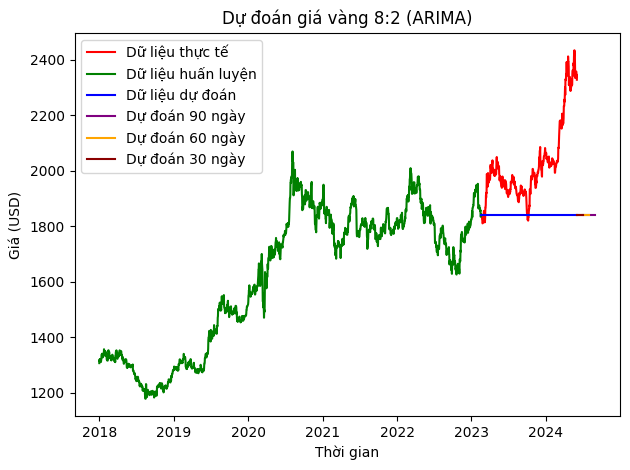

In [ ]:
last_day_number =  (df_gold['Day Number'].max())
last_date = (df_gold['Date'].iloc[-1])

# Dự đoán 90 ngày tiếp theo
n_forecasts = 90
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecasts)
future_day_numbers = range(last_day_number + 1, last_day_number + 1 + n_forecasts)

future_data = pd.DataFrame({'Date': future_dates, 'Day Number': future_day_numbers})
predict_results = model_fit.forecast(steps=(len(g_test_data_2) + len(future_dates)))[-n_forecasts:]
predict_results = np.array(predict_results, dtype=float)
future_data['Price Predict'] = predict_results

# Trực quan hóa kết quả
plt.plot(g_test_data_2['Date'], g_test_data_2['Actual Price'], label='Dữ liệu thực tế', color='red')
plt.plot(g_train_data_8['Date'], g_train_data_8['Train Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(g_test_data_2['Date'], g_test_data_2['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data['Date'], future_data['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data['Date'].iloc[31:60], future_data['Price Predict'].iloc[31:60], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data['Date'].iloc[0:30], future_data['Price Predict'].iloc[0:30], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá vàng 8:2 (ARIMA)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

##### Đánh giá mô hình

In [ ]:
rmse = calculate_rmse(g_test_data_2['Actual Price'].values, g_test_data_2['Price Predict'].values)
mape = calculate_mape(g_test_data_2['Actual Price'].values, g_test_data_2['Price Predict'].values)
mae = calculate_mae(g_test_data_2['Actual Price'].values, g_test_data_2['Price Predict'].values)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 235.88672285088404
MAPE: 8.860849044749754%
MAE: 188.22330934455465


#### 1.3 Tỉ lệ train, 7:3

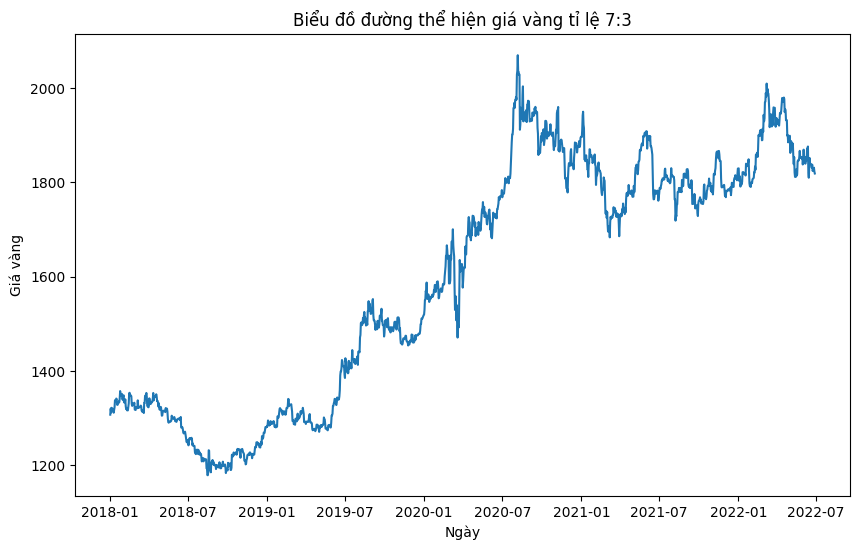

In [ ]:
# Biểu đồ dữ liệu giá vàng ban đầu
plt.figure(figsize=(10, 6))
plt.plot(g_train_data_7['Date'], g_train_data_7['Train Price'])
plt.title('Biểu đồ đường thể hiện giá vàng tỉ lệ 7:3')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.show()

##### **Tạo, huấn luyện mô hình và dự báo**

In [ ]:
# Fit mô hình với các tham số tốt nhất được tìm kiếm(0, 1, 0)
model = ARIMA(g_train_data_7['Train Price'], order=(0, 1, 0))
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
g_predictions_3 = model_fit.forecast(steps=len(g_test_data_3))
g_test_data_3.insert(1, 'Price Predict', g_predictions_3)

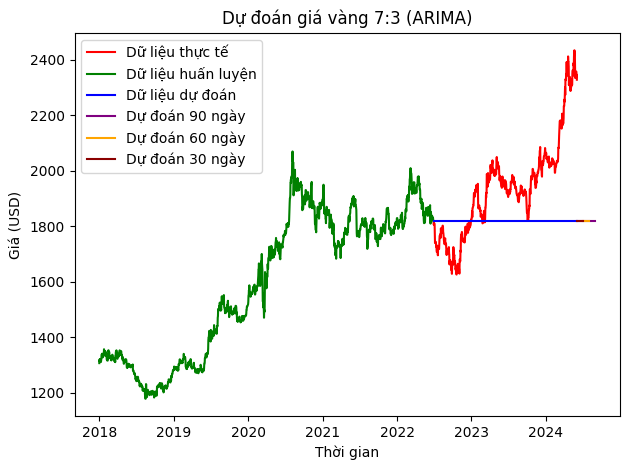

In [ ]:
last_day_number =  (df_gold['Day Number'].max())
last_date = (df_gold['Date'].iloc[-1])

# Dự đoán 90 ngày tiếp theo
n_forecasts = 90
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecasts)
future_day_numbers = range(last_day_number + 1, last_day_number + 1 + n_forecasts)

future_data = pd.DataFrame({'Date': future_dates, 'Day Number': future_day_numbers})
predict_results = model_fit.forecast(steps=(len(g_test_data_3) + len(future_dates)))[-n_forecasts:]
predict_results = np.array(predict_results, dtype=float)
future_data['Price Predict'] = predict_results

# Trực quan hóa kết quả
plt.plot(g_test_data_3['Date'], g_test_data_3['Actual Price'], label='Dữ liệu thực tế', color='red')
plt.plot(g_train_data_7['Date'], g_train_data_7['Train Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(g_test_data_3['Date'], g_test_data_3['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data['Date'], future_data['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data['Date'].iloc[31:60], future_data['Price Predict'].iloc[31:60], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data['Date'].iloc[0:30], future_data['Price Predict'].iloc[0:30], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá vàng 7:3 (ARIMA)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

##### Đánh giá mô hình

In [ ]:
rmse = calculate_rmse(g_test_data_3['Actual Price'].values, g_test_data_3['Price Predict'].values)
mape = calculate_mape(g_test_data_3['Actual Price'].values, g_test_data_3['Price Predict'].values)
mae = calculate_mae(g_test_data_3['Actual Price'].values, g_test_data_3['Price Predict'].values)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 215.4987216051519
MAPE: 8.235574370897949%
MAE: 167.9144495917558


### 2.Áp dụng mô hình để dự đoán cho dữ liệu về giá bạc

#### Kiểm tra tính mùa vụ của bộ dữ liệu

In [ ]:
# Tải dữ liệu từ dataset
df_silver = pd.read_csv('/content/drive/MyDrive/PTDLKD/Dataset/silver_price_2018_2024.csv')

In [ ]:
df_silver.describe()

,Value (USD per troy ounce)
count,2344.000000
mean,20.793671
std,4.275718
min,12.111723
25%,16.642140
50%,21.955000
75%,24.208035
max,32.161800


In [ ]:
# Chuyển đổi kiểu dữ liệu
df_silver['Date'] = pd.to_datetime(df_silver['Date'])
df_silver['Day Number'] = df_silver['Date'].rank(method='dense').astype(int)
df_silver.columns = ['Date', 'Price', 'Day Number']

# Xoá dữ liệu bị null
df_silver = df_silver.dropna()

df_silver

,Date,Price,Day Number
0,2018-01-01,16.993771,1
1,2018-01-02,17.196475,2
2,2018-01-03,17.112426,3
3,2018-01-04,17.200338,4
4,2018-01-05,17.220985,5
...,...,...,...
2339,2024-05-28,31.790544,2340
2340,2024-05-29,31.992130,2341
2341,2024-05-30,31.825860,2342
2342,2024-05-31,31.137894,2343


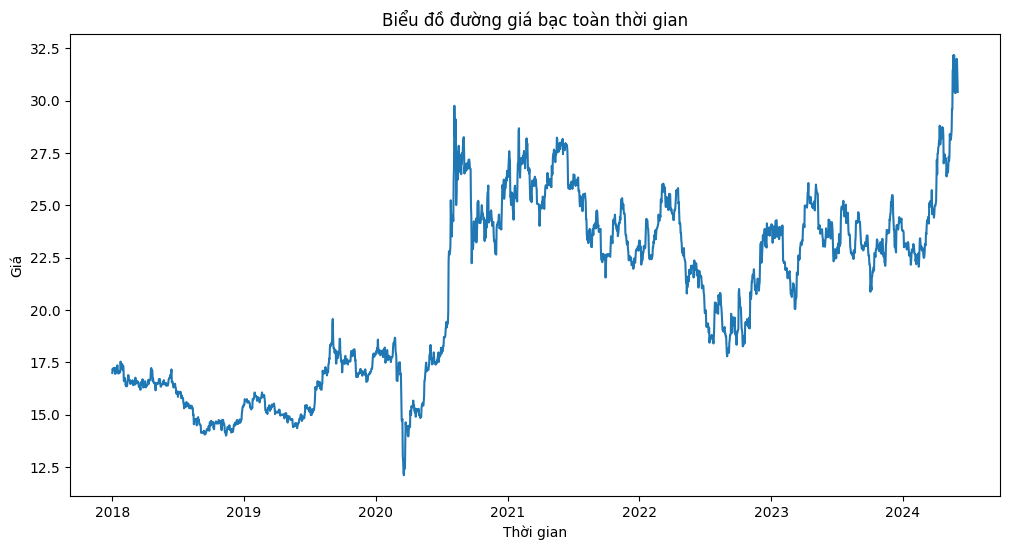

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_silver['Date'],df_silver['Price'])
plt.title('Biểu đồ đường giá bạc toàn thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.show()

**Bộ dữ liệu giá bạc**
- Các biểu đồ có biến động gần giống giá vàng nhưng biểu đồ ACF của giá bạc ở các độ trễ cuối có tương quan yếu hơn so với giá vàng nhưng vẫn ở khoảng mức 0.8
- Biểu đồ biểu diễn sai số có mức biến động khá thấp vào ổn định từ năm 2018 đến các tháng đầu năm 2020 nhưng về sau có sự biến động lớn và không ổn định.
- Tuy vậy, nhìn chung các biểu đồ cũng mang các đặc điểm như giá vàng nên ta thiết lập thông số autoarima giống như giá vàng.

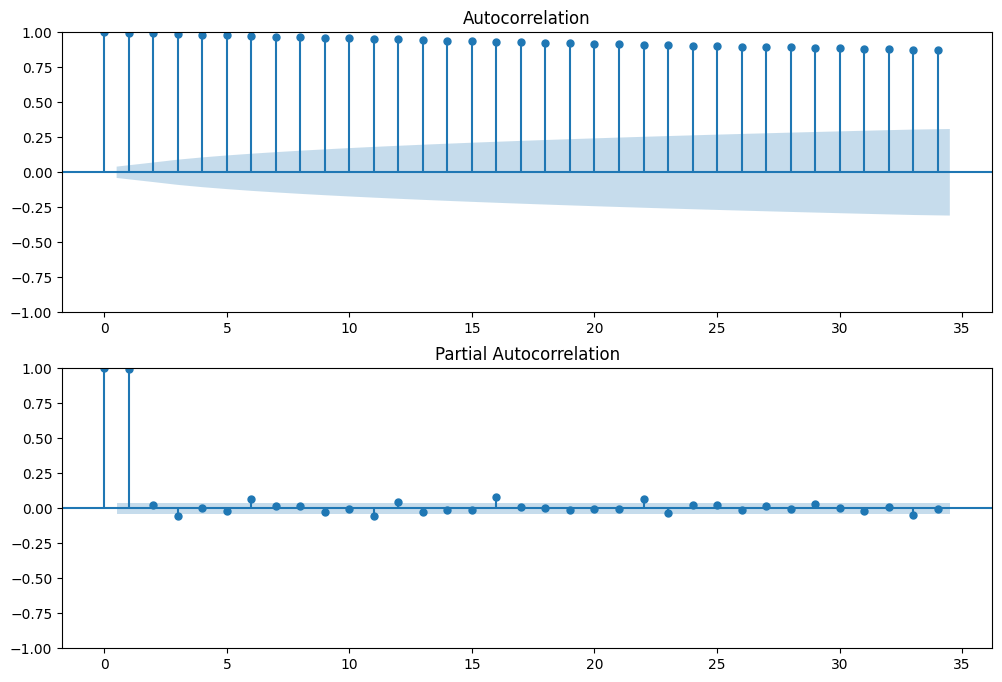

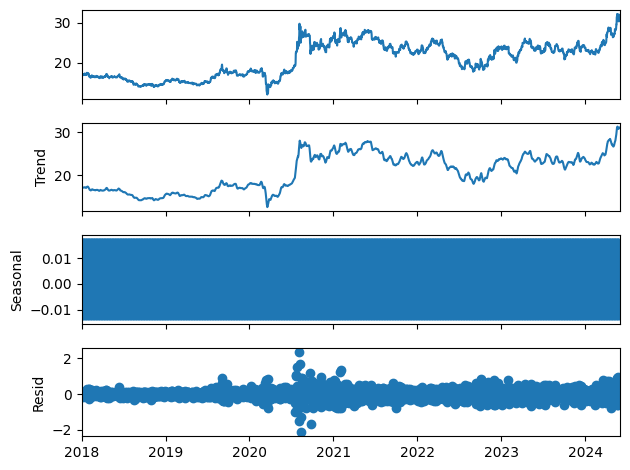

In [ ]:
# ACF và PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_silver['Price'], ax=ax[0])
plot_pacf(df_silver['Price'], ax=ax[1])
plt.show()

# Seasonal decomposition
df_temp = pd.DataFrame({'Price': df_silver['Price'].values}, index=df_silver['Date'])
result = seasonal_decompose(df_temp, model='additive')
result.plot()
plt.show()

#### Chia tập huấn luyện, kiểm tra

In [ ]:
# Kích thước tập train, test đối với từng tỉ lệ
train_size_9 = int(0.9 * len(df_silver))
test_size_1 = len(df_silver) - train_size_9
train_size_8 = int(0.8 * len(df_silver))
test_size_2 = len(df_silver) - train_size_8
train_size_7 = int(0.7 * len(df_silver))
test_size_3 = len(df_silver) - train_size_7

print(f'Tỉ lệ 9:1, train: {train_size_9}, test: {test_size_1}')
print(f'Tỉ lệ 8:2, train: {train_size_8}, test: {test_size_2}')
print(f'Tỉ lệ 7:3, train: {train_size_7}, test: {test_size_3}')

Tỉ lệ 9:1, train: 2109, test: 235
Tỉ lệ 8:2, train: 1875, test: 469
Tỉ lệ 7:3, train: 1640, test: 704


In [ ]:
# Chia tập dữ liệu huấn luyện, kiểm tra
# Dữ liệu huấn luyện
s_train_data_9 = df_silver.iloc[:train_size_9]
s_train_data_8 = df_silver.iloc[:train_size_8]
s_train_data_7 = df_silver.iloc[:train_size_7]
s_train_data_9.columns = ['Date','Train Price','Day number']
s_train_data_8.columns = ['Date','Train Price','Day number']
s_train_data_7.columns = ['Date','Train Price','Day number']

# Dữ liệu kiểm tra
s_test_data_1 = df_silver.iloc[train_size_9:]
s_test_data_2 = df_silver.iloc[train_size_8:]
s_test_data_3 = df_silver.iloc[train_size_7:]
s_test_data_1.columns = ['Date','Actual Price','Day number']
s_test_data_2.columns = ['Date','Actual Price','Day number']
s_test_data_3.columns = ['Date','Actual Price','Day number']

#### Tỉ lệ dữ liệu 9 : 1

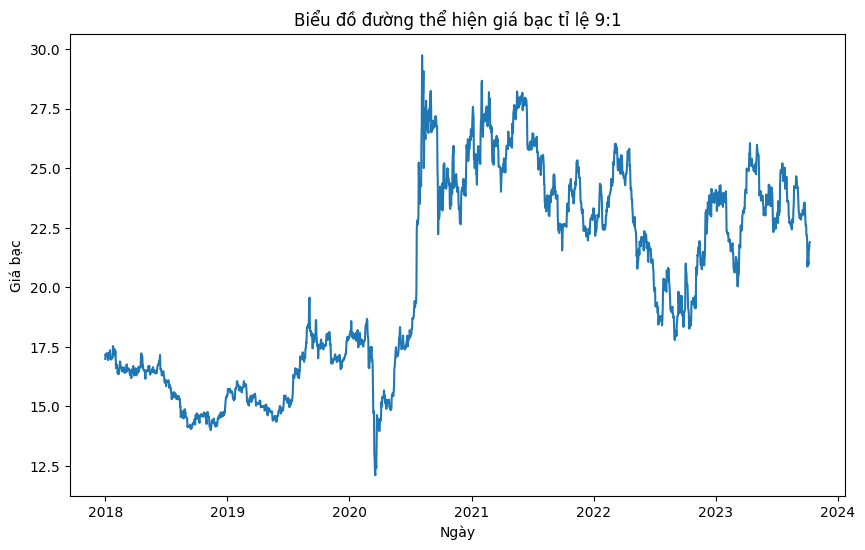

In [ ]:
# Biểu đồ dữ liệu giá bạc ban đầu
plt.figure(figsize=(10, 6))
plt.plot(s_train_data_9['Date'], s_train_data_9['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạc tỉ lệ 9:1')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.show()

##### Tạo, huấn luyện mô hình và dự đoán

In [ ]:
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(s_train_data_9['Train Price'], seasonal=False, with_intercept = True, trend='t', trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1359.326, Time=1.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1356.180, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1352.431, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1352.682, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1356.180, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1353.506, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1353.283, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1355.508, Time=0.74 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1352.431, Time=0.29 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 5.364 seconds


In [ ]:
# Fit mô hình với các tham số tốt nhất được tìm kiếm(1, 1, 0)
model = ARIMA(s_train_data_9['Train Price'], order=(1, 1, 0))
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
s_predictions_1 = model_fit.forecast(steps=len(s_test_data_1))

# g_test_data_1 = g_test_data_1.drop('Price Predict', axis = 1)
s_test_data_1.insert(1, 'Price Predict', s_predictions_1)

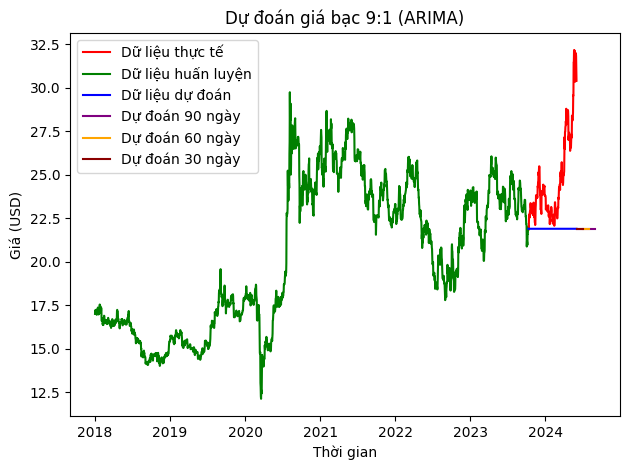

In [ ]:
last_day_number =  (df_silver['Day Number'].max())
last_date = (df_silver['Date'].iloc[-1])

# Dự đoán 90 ngày tiếp theo
n_forecasts = 90
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecasts)
future_day_numbers = range(last_day_number + 1, last_day_number + 1 + n_forecasts)

future_data = pd.DataFrame({'Date': future_dates, 'Day Number': future_day_numbers})
predict_results = model_fit.forecast(steps=(len(s_test_data_1) + len(future_dates)))[-n_forecasts:]
predict_results = np.array(predict_results, dtype=float)
future_data['Price Predict'] = predict_results

# Trực quan hóa kết quả
plt.plot(s_test_data_1['Date'], s_test_data_1['Actual Price'], label='Dữ liệu thực tế', color='red')
plt.plot(s_train_data_9['Date'], s_train_data_9['Train Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(s_test_data_1['Date'], s_test_data_1['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data['Date'], future_data['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data['Date'].iloc[31:60], future_data['Price Predict'].iloc[31:60], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data['Date'].iloc[0:30], future_data['Price Predict'].iloc[0:30], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạc 9:1 (ARIMA)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
mape = calculate_mape(s_test_data_1['Actual Price'].values, s_test_data_1['Price Predict'].values)
rmse = calculate_rmse(s_test_data_1['Actual Price'].values, s_test_data_1['Price Predict'].values)
mae = calculate_mae(s_test_data_1['Actual Price'].values, s_test_data_1['Price Predict'].values)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 3.8219522121863254
MAPE: 10.814599414689656%
MAE: 2.8823377280732045


#### Tỉ lệ dữ liệu 8 : 2

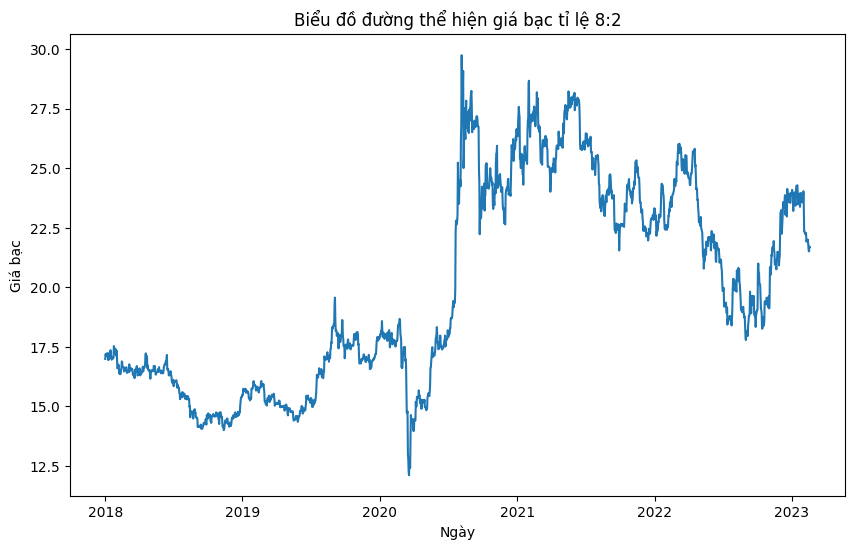

In [ ]:
# Biểu đồ dữ liệu giá bạc ban đầu
plt.figure(figsize=(10, 6))
plt.plot(s_train_data_8['Date'], s_train_data_8['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạc tỉ lệ 8:2')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.show()

##### Tạo, huấn luyện mô hình và dự đoán

In [ ]:
# Fit mô hình với các tham số tốt nhất được tìm kiếm(1, 1, 0)
model = ARIMA(s_train_data_8['Train Price'], order=(1, 1, 0))
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
s_predictions_2 = model_fit.forecast(steps=len(s_test_data_2))

s_test_data_2.insert(1, 'Price Predict', s_predictions_2)

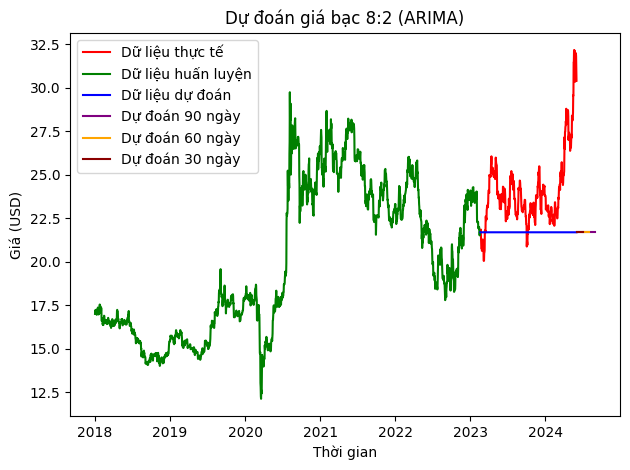

In [ ]:
last_day_number =  (df_silver['Day Number'].max())
last_date = (df_silver['Date'].iloc[-1])

# Dự đoán 90 ngày tiếp theo
n_forecasts = 90
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecasts)
future_day_numbers = range(last_day_number + 1, last_day_number + 1 + n_forecasts)

future_data = pd.DataFrame({'Date': future_dates, 'Day Number': future_day_numbers})
predict_results = model_fit.forecast(steps=(len(s_test_data_2) + len(future_dates)))[-n_forecasts:]
predict_results = np.array(predict_results, dtype=float)
future_data['Price Predict'] = predict_results

# Trực quan hóa kết quả
plt.plot(s_test_data_2['Date'], s_test_data_2['Actual Price'], label='Dữ liệu thực tế', color='red')
plt.plot(s_train_data_8['Date'], s_train_data_8['Train Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(s_test_data_2['Date'], s_test_data_2['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data['Date'], future_data['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data['Date'].iloc[31:60], future_data['Price Predict'].iloc[31:60], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data['Date'].iloc[0:30], future_data['Price Predict'].iloc[0:30], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạc 8:2 (ARIMA)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
mape = calculate_mape(s_test_data_2['Actual Price'].values, s_test_data_2['Price Predict'].values)
rmse = calculate_rmse(s_test_data_2['Actual Price'].values, s_test_data_2['Price Predict'].values)
mae = calculate_mae(s_test_data_2['Actual Price'].values, s_test_data_2['Price Predict'].values)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 3.209613481402454
MAPE: 9.808482876615225%
MAE: 2.501125970491345


#### Tỉ lệ dữ liệu 7 : 3

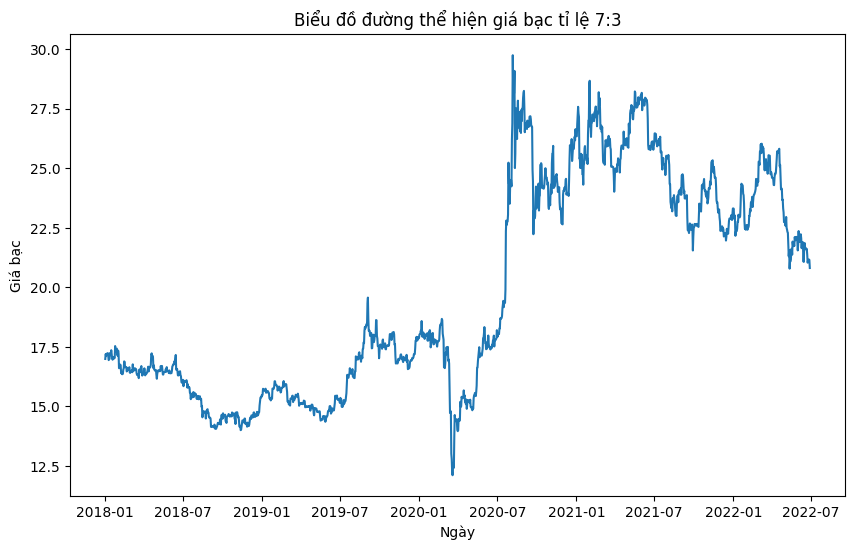

In [ ]:
# Biểu đồ dữ liệu giá bạc ban đầu
plt.figure(figsize=(10, 6))
plt.plot(s_train_data_7['Date'], s_train_data_7['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạc tỉ lệ 7:3')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.show()

##### Tạo, huấn luyện mô hình và dự đoán

In [ ]:
# Fit mô hình với các tham số tốt nhất được tìm kiếm(1, 1, 0)
model = ARIMA(s_train_data_7['Train Price'], order=(1, 1, 0))
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
s_predictions_3 = model_fit.forecast(steps=len(s_test_data_3))

s_test_data_3.insert(1, 'Price Predict', s_predictions_3)

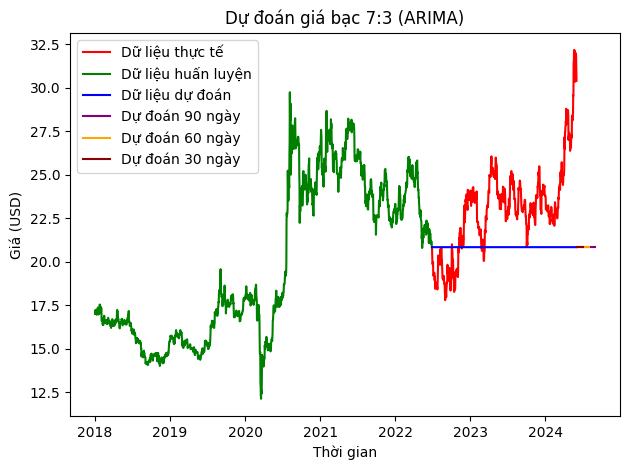

In [ ]:
last_day_number =  (df_silver['Day Number'].max())
last_date = (df_silver['Date'].iloc[-1])

# Dự đoán 90 ngày tiếp theo
n_forecasts = 90
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecasts)
future_day_numbers = range(last_day_number + 1, last_day_number + 1 + n_forecasts)

future_data = pd.DataFrame({'Date': future_dates, 'Day Number': future_day_numbers})
predict_results = model_fit.forecast(steps=(len(s_test_data_3) + len(future_dates)))[-n_forecasts:]
predict_results = np.array(predict_results, dtype=float)
future_data['Price Predict'] = predict_results

# Trực quan hóa kết quả
plt.plot(s_test_data_3['Date'], s_test_data_3['Actual Price'], label='Dữ liệu thực tế', color='red')
plt.plot(s_train_data_7['Date'], s_train_data_7['Train Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(s_test_data_3['Date'], s_test_data_3['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data['Date'], future_data['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data['Date'].iloc[31:60], future_data['Price Predict'].iloc[31:60], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data['Date'].iloc[0:30], future_data['Price Predict'].iloc[0:30], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạc 7:3 (ARIMA)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
mape = calculate_mape(s_test_data_3['Actual Price'].values, s_test_data_3['Price Predict'].values)
rmse = calculate_rmse(s_test_data_3['Actual Price'].values, s_test_data_3['Price Predict'].values)
mae = calculate_mae(s_test_data_3['Actual Price'].values, s_test_data_3['Price Predict'].values)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 3.375102921409426
MAPE: 11.4329179491037%
MAE: 2.7649125647729744


### 3.Áp dụng mô hình để dự đoán cho dữ liệu về giá bạch kim

#### Kiểm tra tính mùa vụ của bộ dữ liệu

In [ ]:
# Tải dữ liệu từ dataset
df_platium = pd.read_csv('/content/drive/MyDrive/PTDLKD/Dataset/platium_price_2018_2024.csv')

In [ ]:
df_platium.describe()

,Value (USD per troy ounce)
count,2344.000000
mean,941.094637
std,105.276473
min,591.460359
25%,867.689819
50%,931.069382
75%,998.809803
max,1306.683681


In [ ]:
# Chuyển đổi kiểu dữ liệu
df_platium['Date'] = pd.to_datetime(df_platium['Date'])
df_platium['Day Number'] = df_platium['Date'].rank(method='dense').astype(int)
df_platium.columns = ['Date', 'Price', 'Day Number']

# Xoá dữ liệu bị null
df_platium = df_platium.dropna()

df_platium

,Date,Price,Day Number
0,2018-01-01,930.030587,1
1,2018-01-02,944.375754,2
2,2018-01-03,954.910273,3
3,2018-01-04,960.864535,4
4,2018-01-05,969.196081,5
...,...,...,...
2339,2024-05-28,1062.333141,2340
2340,2024-05-29,1063.887962,2341
2341,2024-05-30,1036.777827,2342
2342,2024-05-31,1027.966127,2343


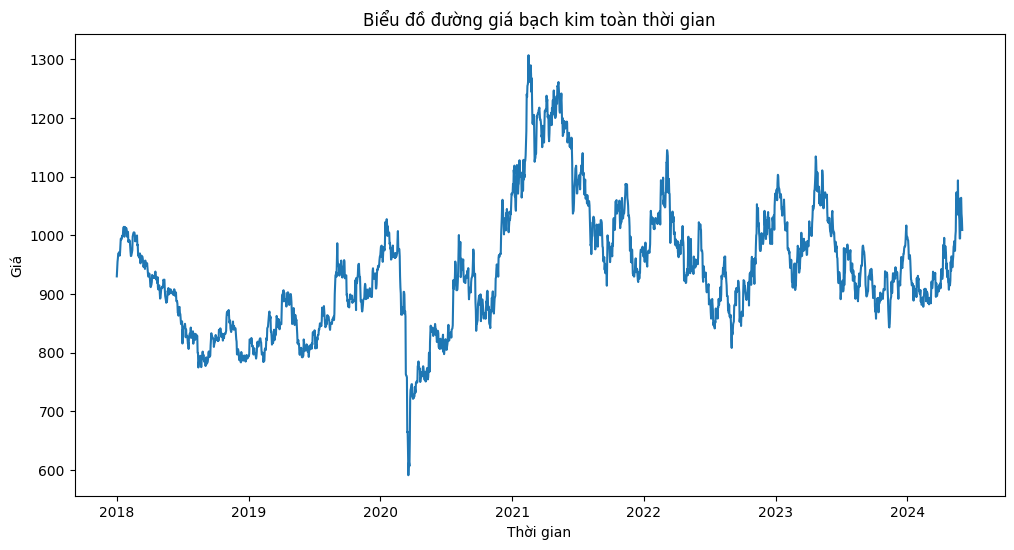

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_platium['Date'],df_platium['Price'])
plt.title('Biểu đồ đường giá bạch kim toàn thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.show()

**Bộ dữ liệu giá bạc**
- Các biểu đồ có sự biến động mạnh như giá vàng. Như vậy các thông số thiết lập như giá vàng.

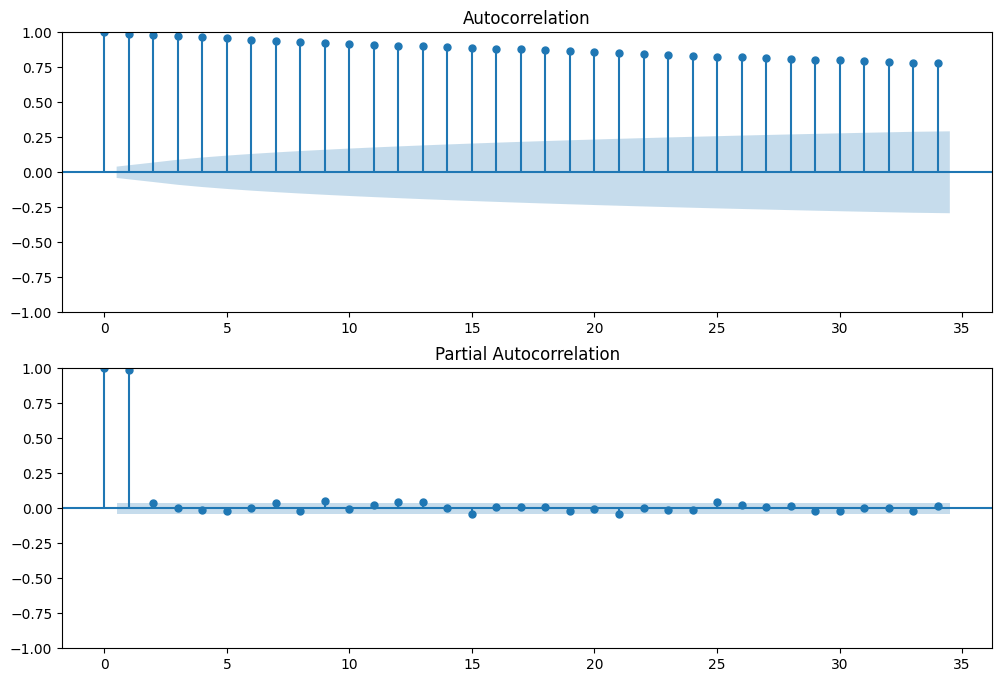

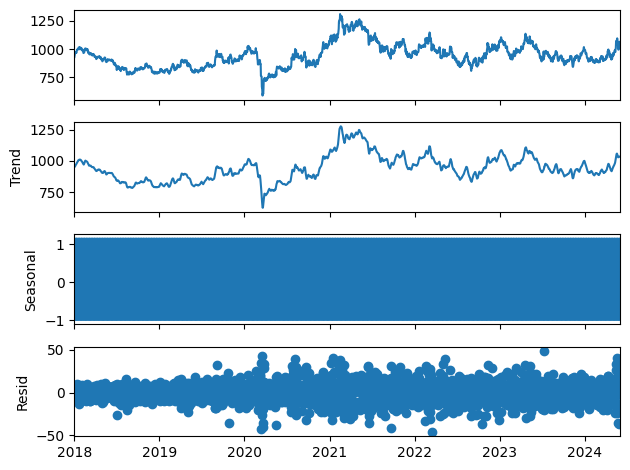

In [ ]:
# ACF và PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_platium['Price'], ax=ax[0])
plot_pacf(df_platium['Price'], ax=ax[1])
plt.show()

# Seasonal decomposition
df_temp = pd.DataFrame({'Price': df_platium['Price'].values}, index=df_platium['Date'])
result = seasonal_decompose(df_temp, model='additive')
result.plot()
plt.show()

#### Chia tập huấn luyện, kiểm tra

In [ ]:
# Kích thước tập train, test đối với từng tỉ lệ
train_size_9 = int(0.9 * len(df_platium))
test_size_1 = len(df_platium) - train_size_9
train_size_8 = int(0.8 * len(df_platium))
test_size_2 = len(df_platium) - train_size_8
train_size_7 = int(0.7 * len(df_platium))
test_size_3 = len(df_platium) - train_size_7

print(f'Tỉ lệ 9:1, train: {train_size_9}, test: {test_size_1}')
print(f'Tỉ lệ 8:2, train: {train_size_8}, test: {test_size_2}')
print(f'Tỉ lệ 7:3, train: {train_size_7}, test: {test_size_3}')

Tỉ lệ 9:1, train: 2109, test: 235
Tỉ lệ 8:2, train: 1875, test: 469
Tỉ lệ 7:3, train: 1640, test: 704


In [ ]:
# Chia tập dữ liệu huấn luyện, kiểm tra
# Dữ liệu huấn luyện
p_train_data_9 = df_platium.iloc[:train_size_9]
p_train_data_8 = df_platium.iloc[:train_size_8]
p_train_data_7 = df_platium.iloc[:train_size_7]
p_train_data_9.columns = ['Date','Train Price','Day number']
p_train_data_8.columns = ['Date','Train Price','Day number']
p_train_data_7.columns = ['Date','Train Price','Day number']

# Dữ liệu kiểm tra
p_test_data_1 = df_platium.iloc[train_size_9:]
p_test_data_2 = df_platium.iloc[train_size_8:]
p_test_data_3 = df_platium.iloc[train_size_7:]
p_test_data_1.columns = ['Date','Actual Price','Day number']
p_test_data_2.columns = ['Date','Actual Price','Day number']
p_test_data_3.columns = ['Date','Actual Price','Day number']

#### Tỉ lệ dữ liệu 9 : 1

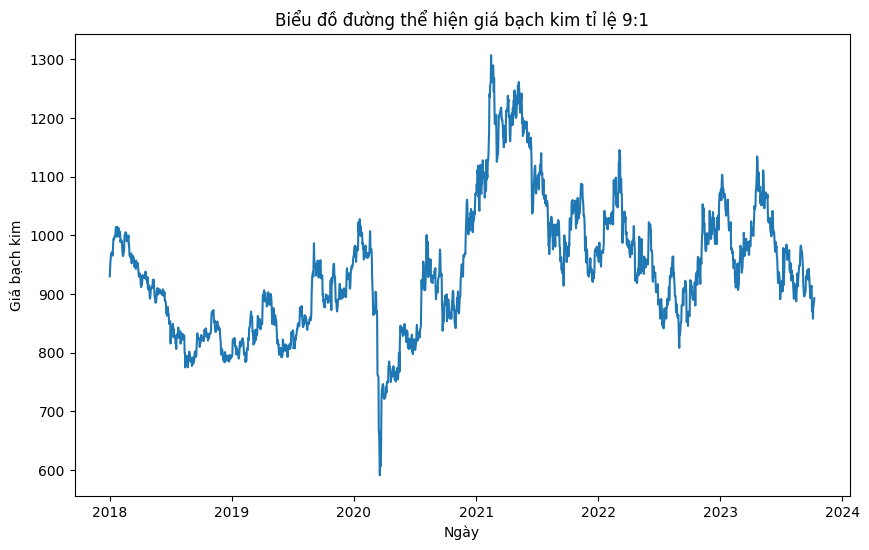

In [ ]:
# Biểu đồ dữ liệu giá bạch kim ban đầu
plt.figure(figsize=(10, 6))
plt.plot(p_train_data_9['Date'], p_train_data_9['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim tỉ lệ 9:1')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.show()

##### Tạo, huấn luyện mô hình và dự đoán

In [ ]:
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(p_train_data_9['Train Price'], seasonal=False, with_intercept = True, trend='t', trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17175.077, Time=2.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17174.975, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17173.155, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17173.110, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17174.975, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17175.092, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17175.079, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17177.045, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17173.110, Time=0.83 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 6.345 seconds


In [ ]:
# Fit mô hình với các tham số tốt nhất được tìm kiếm(0,1,1)
model = ARIMA(p_train_data_9['Train Price'], order=(0, 1, 1))
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
p_predictions_1 = model_fit.forecast(steps=len(p_test_data_1))

# g_test_data_1 = g_test_data_1.drop('Price Predict', axis = 1)
p_test_data_1.insert(1, 'Price Predict', p_predictions_1)

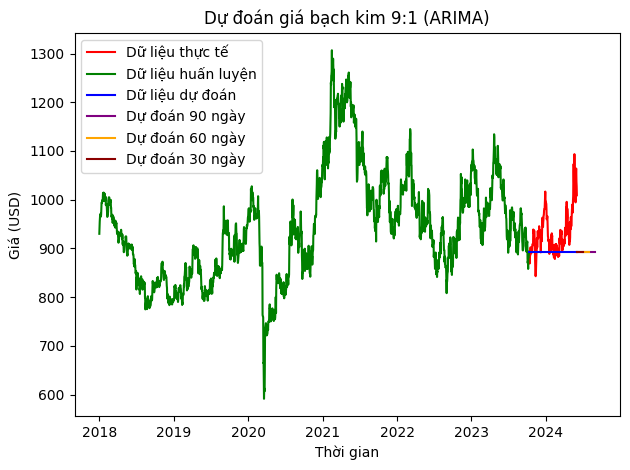

In [ ]:
last_day_number =  (df_silver['Day Number'].max())
last_date = (df_silver['Date'].iloc[-1])

# Dự đoán 90 ngày tiếp theo
n_forecasts = 90
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecasts)
future_day_numbers = range(last_day_number + 1, last_day_number + 1 + n_forecasts)

future_data = pd.DataFrame({'Date': future_dates, 'Day Number': future_day_numbers})
predict_results = model_fit.forecast(steps=(len(p_test_data_1) + len(future_dates)))[-n_forecasts:]
predict_results = np.array(predict_results, dtype=float)
future_data['Price Predict'] = predict_results

# Trực quan hóa kết quả
plt.plot(p_test_data_1['Date'], p_test_data_1['Actual Price'], label='Dữ liệu thực tế', color='red')
plt.plot(p_train_data_9['Date'], p_train_data_9['Train Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(p_test_data_1['Date'], p_test_data_1['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data['Date'], future_data['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data['Date'].iloc[31:60], future_data['Price Predict'].iloc[31:60], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data['Date'].iloc[0:30], future_data['Price Predict'].iloc[0:30], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạch kim 9:1 (ARIMA)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
mape = calculate_mape(p_test_data_1['Actual Price'].values, p_test_data_1['Price Predict'].values)
rmse = calculate_rmse(p_test_data_1['Actual Price'].values, p_test_data_1['Price Predict'].values)
mae = calculate_mae(p_test_data_1['Actual Price'].values, p_test_data_1['Price Predict'].values)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 61.020107798699925
MAPE: 4.53625305823751%
MAE: 44.09407032164267


#### Tỉ lệ dữ liệu 8 : 2

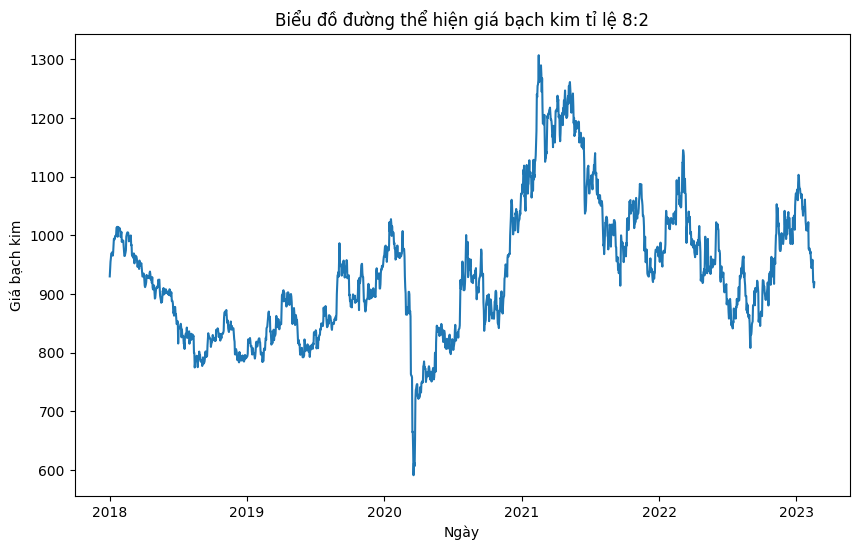

In [ ]:
# Biểu đồ dữ liệu giá bạch kim ban đầu
plt.figure(figsize=(10, 6))
plt.plot(p_train_data_8['Date'], p_train_data_8['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim tỉ lệ 8:2')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.show()

##### Tạo, huấn luyện mô hình và dự đoán

In [ ]:
# Fit mô hình với các tham số tốt nhất được tìm kiếm(0, 1, 1)
model = ARIMA(p_train_data_8['Train Price'], order=(0, 1, 1))
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
p_predictions_2 = model_fit.forecast(steps=len(p_test_data_2))
p_test_data_2.insert(1, 'Price Predict', p_predictions_2)

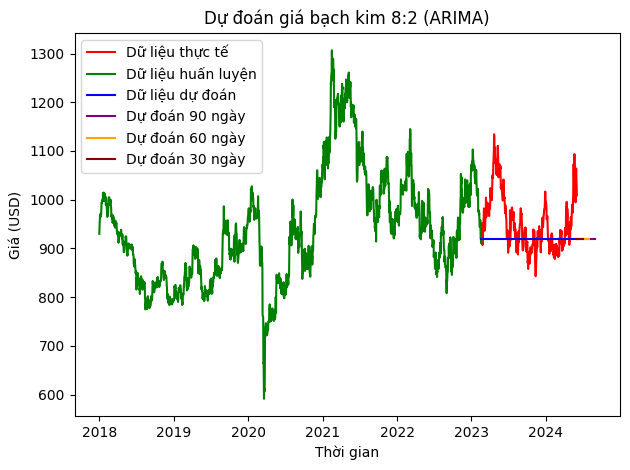

In [ ]:
last_day_number =  (df_platium['Day Number'].max())
last_date = (df_platium['Date'].iloc[-1])

# Dự đoán 90 ngày tiếp theo
n_forecasts = 90
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecasts)
future_day_numbers = range(last_day_number + 1, last_day_number + 1 + n_forecasts)

future_data = pd.DataFrame({'Date': future_dates, 'Day Number': future_day_numbers})
predict_results = model_fit.forecast(steps=(len(p_test_data_2) + len(future_dates)))[-n_forecasts:]
predict_results = np.array(predict_results, dtype=float)
future_data['Price Predict'] = predict_results

# Trực quan hóa kết quả
plt.plot(p_test_data_2['Date'], p_test_data_2['Actual Price'], label='Dữ liệu thực tế', color='red')
plt.plot(p_train_data_8['Date'], p_train_data_8['Train Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(p_test_data_2['Date'], p_test_data_2['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data['Date'], future_data['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data['Date'].iloc[31:60], future_data['Price Predict'].iloc[31:60], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data['Date'].iloc[0:30], future_data['Price Predict'].iloc[0:30], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạch kim 8:2 (ARIMA)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
mape = calculate_mape(p_test_data_2['Actual Price'].values, p_test_data_2['Price Predict'].values)
rmse = calculate_rmse(p_test_data_2['Actual Price'].values, p_test_data_2['Price Predict'].values)
mae = calculate_mae(p_test_data_2['Actual Price'].values, p_test_data_2['Price Predict'].values)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 66.17753812774329
MAPE: 4.765450766571688%
MAE: 47.56622451188722


#### Tỉ lệ dữ liệu 7 : 3

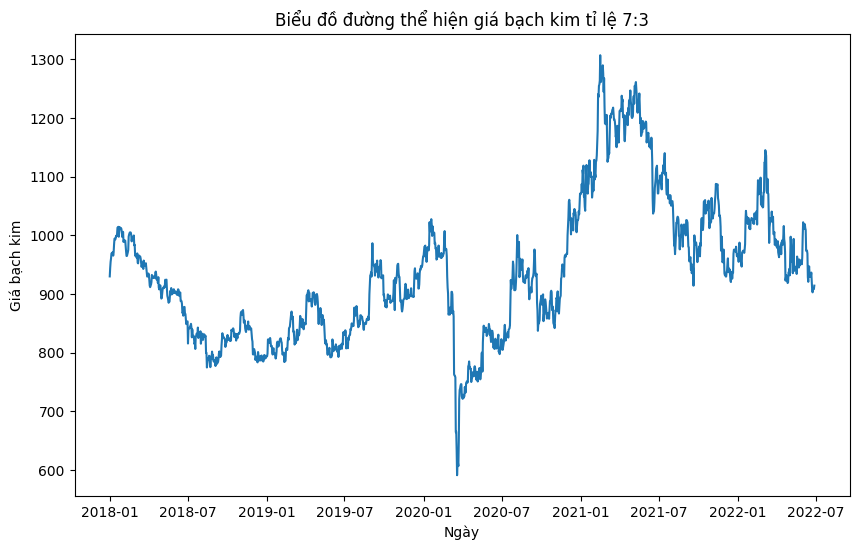

In [ ]:
# Biểu đồ dữ liệu giá bạch kim ban đầu
plt.figure(figsize=(10, 6))
plt.plot(p_train_data_7['Date'], p_train_data_7['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim tỉ lệ 7:3')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.show()

##### Tạo, huấn luyện mô hình và dự đoán

In [ ]:
# Fit mô hình với các tham số tốt nhất được tìm kiếm(0, 1, 1)
model = ARIMA(p_train_data_7['Train Price'], order=(0, 1, 1))
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
p_predictions_3 = model_fit.forecast(steps=len(p_test_data_3))

p_test_data_3.insert(1, 'Price Predict', p_predictions_3)

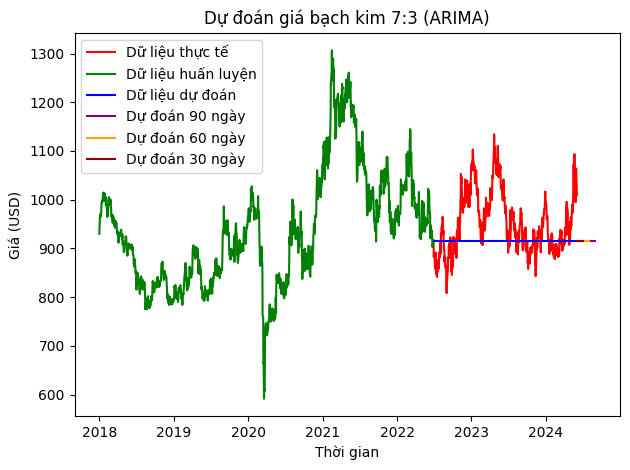

In [ ]:
last_day_number =  (df_platium['Day Number'].max())
last_date = (df_platium['Date'].iloc[-1])

# Dự đoán 90 ngày tiếp theo
n_forecasts = 90
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecasts)
future_day_numbers = range(last_day_number + 1, last_day_number + 1 + n_forecasts)

future_data = pd.DataFrame({'Date': future_dates, 'Day Number': future_day_numbers})
predict_results = model_fit.forecast(steps=(len(p_test_data_3) + len(future_dates)))[-n_forecasts:]
predict_results = np.array(predict_results, dtype=float)
future_data['Price Predict'] = predict_results

# Trực quan hóa kết quả
plt.plot(p_test_data_3['Date'], p_test_data_3['Actual Price'], label='Dữ liệu thực tế', color='red')
plt.plot(p_train_data_7['Date'], p_train_data_7['Train Price'], label='Dữ liệu huấn luyện', color='green')
plt.plot(p_test_data_3['Date'], p_test_data_3['Price Predict'], label='Dữ liệu dự đoán', color='blue')
plt.plot(future_data['Date'], future_data['Price Predict'], label='Dự đoán 90 ngày', color='purple')
plt.plot(future_data['Date'].iloc[31:60], future_data['Price Predict'].iloc[31:60], label='Dự đoán 60 ngày', color='orange')
plt.plot(future_data['Date'].iloc[0:30], future_data['Price Predict'].iloc[0:30], label='Dự đoán 30 ngày', color='darkred')

plt.title('Dự đoán giá bạch kim 7:3 (ARIMA)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
mape = calculate_mape(p_test_data_3['Actual Price'].values, p_test_data_3['Price Predict'].values)
rmse = calculate_rmse(p_test_data_3['Actual Price'].values, p_test_data_3['Price Predict'].values)
mae = calculate_mae(p_test_data_3['Actual Price'].values, p_test_data_3['Price Predict'].values)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 72.28450493634385
MAPE: 5.445066048992056%
MAE: 54.04855576682087
